## MEAM 5460 HW3
### Author: Nathaniel Ruhl

### Introduction

In order to predict the performance of a rotor, it is necessary to calculate the inflow induced by the rotor, $\lambda$. Blade element momentum theory (BEMT) is a powerfule tool to predict the inflow and the performance measures, such as the coefficients of thrust and power. Moreover, BEMT is versatile enough to account for changes in blade chord, twist, taper, and tip losses, thus providing a useful tool to compare and analyze different rotor designs.

In this report, I present a tool that I have made using BEMT to calculate induced inflow $\lambda$, distributions of local coefficients of thrust and power $c_T$ and $c_P$, as well as their total counterparts $C_T$ and $C_P$. The script "hw3.py" contains the functions to perform BEMT analysis and the code in this notebook demonstrates how to use the tool. In this version of the BEMT tool, I make a couple simplifying assumptions which are listed below. In the project assignment, I will break assumptions 2-5.

1. The rotor is in hover: $\lambda_c=0$
2. The rotor has an ideal twist distibution specified by the input collective at 75%R: $\theta(r)=0.75\theta_{75}/r$
3. Constant blade chord (no taper variation)
4. Linear thin airfoil assumption: $c_{l,\alpha}=2\pi$ lift-curve slope
5. Tip losses are ignored

### Assumptions

The calculations use an MSL density of 0.002378 slug/ft^3.

The analysis below is performed on a rotor blade with the folowing specifications:

- Nb = 1  # number of blades
- c = 2.0 # Chord length, ft
- vtip = 650 # ft/sec
- R = 30 # ft
- sigma = Nb*c/(np.pi*R)  # solidity
- cl_slope = 2*np.pi # Lift-curve slope

The variables listed above are the default instance variables for a 'Rotor' object. After a rotor object is defined via rotor = Rotor(), you can change the properties via 'rotor.c=3', etc...

### BEMT Equations

BEMT predicts the local coefficiecients of thrust and power to be

$$c_T = 4\lambda^2 r$$
$$c_P = 4\lambda^3 r$$

where 
$$\lambda(r) = \frac{\sigma c_{l,\alpha}}{16} \left( \sqrt{1+\frac{32}{\sigma c_{l,\alpha}} \theta(r) r} - 1 \right)$$ and the rotor solidity is $\sigma=\frac{N_b c}{\pi R}$.

As stated previously, in this report, we make the simplifying assumptions that

$$\theta(r)=0.75 \theta_{75}/r, \quad c_{l,\alpha}=2 \pi .$$

In this case, $\lambda$ is independent of $r$:

$$\lambda = \frac{\sigma c_{l,\alpha}}{16} \left( \sqrt{1+\frac{32}{\sigma c_{l,\alpha}} 0.75 \theta_{75}} - 1 \right)$$

Therefore, the total coefficients of thrust and power exhibit a closed form solution:

$$C_T = 4 \lambda^2 \int_0^1 r dr = 2 \lambda^2 $$
$$C_P = 4 \lambda^3 \int_0^1 r dr = 2 \lambda^3. $$

In order to prepare for Project 1 where we remove some of our assumptions, I implemented gaussian quadrature to evaluate the numerical integrals. Lastly, we can write the local angle of attack of an airfoil as

$$\alpha(r) = \theta(r) - \phi(r)$$

where $\phi(r)$ is the induced inflow angle. In hover, the inflow angle can be written as:

$$\phi(r) = \frac{\lambda(r)}{r}$$

### Comparison to Momentum Theory

In order to validate our results, we will compare the BEMT to blade-less rotor-disk momentum theory. In theis theor, the induced inflow in hower is equal to $\lambda_h = \sqrt{C_T/2}$, where we will use the value of $C_T$ from BEMT in order to evaluate $\lambda_h$.

In [2]:
# import standard libraries
import importlib
import numpy as np
import matplotlib.pyplot as plt

# import local modules (these scripts must be in the working directory)
from Rotor import Rotor  # Rotor object definition
import hw3   # BEMT tool
importlib.reload(hw3)
from hw3 import Theta, Lambda, Alpha, Phi, dCT, dCP, calc_CT_CP

In [3]:
rotor = Rotor()
# Here is where you can change rotor properties with rotor.c=3, etc...
# The two codebloacks above are all that is needed to run a new 

### Analysis

#### Performance Profiles

Let's first consider the profiles of $\lambda$, $c_T$, and $c_P$ as a function of non-dimensional radius. The plots below the expected relationships when the blade has ideal twist: uniform inflow $\lambda$ and $c_T$ and $c_P$ increasing linearly with $r$. For the profiles below, I will consider the profiles at $\theta_{75}=5^\circ$. The plot for $\lambda$ below shows the comparison to momentum theory in the legend. The legend of the thrust and power profiles shows the total $C_T$ and $C_P$ (area under the curve).

(0.0, 15.0)

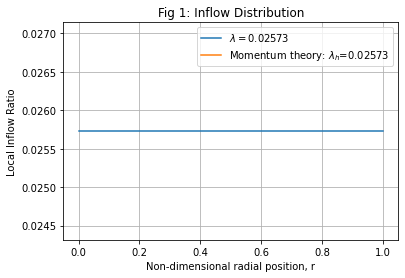

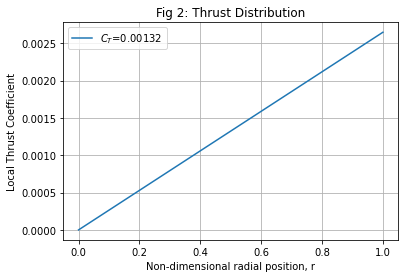

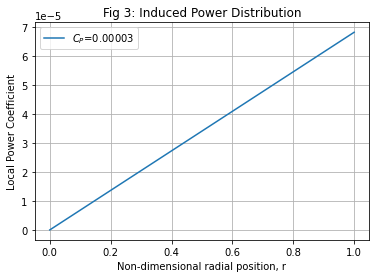

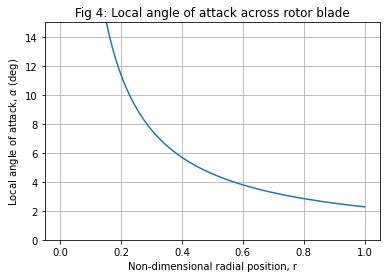

In [4]:
# Code for plotting lmbda, dCT = c_T, and dCP = c_P profiles

theta_75 = np.deg2rad(5)

CT, CP = calc_CT_CP(theta_75, rotor)

rs = np.linspace(0.0001, 1, 100)  # Non-dimensional blade radius

plt.figure(1)
plt.title("Fig 1: Inflow Distribution")
plt.plot(rs, Lambda(rs, theta_75, rotor),label=f"$\lambda={Lambda(1, theta_75, rotor):.5f}$")
plt.plot([],[],label=rf"Momentum theory: $\lambda_h$={np.sqrt(CT/2):.5f}")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Inflow Ratio")
plt.legend()

plt.figure(2)
plt.title("Fig 2: Thrust Distribution")
plt.plot(rs, dCT(rs, theta_75, rotor), label=fr'$C_T$={CT:.5f}')
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Thrust Coefficient")
plt.legend()

plt.figure(3)
plt.title("Fig 3: Induced Power Distribution")
plt.plot(rs, dCP(rs, theta_75, rotor), label=fr'$C_P$={CP:.5f}')
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Power Coefficient")
plt.legend()

plt.figure(4)
plt.title("Fig 4: Local angle of attack across rotor blade")
plt.plot(rs, np.rad2deg(Alpha(rs, theta_75, rotor)))
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel(r"Local angle of attack, $\alpha$ (deg)")
plt.ylim([0,15])

Below, I will plot the profiles at three different input collectives, $\theta_{75}$

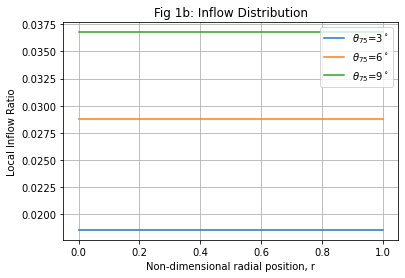

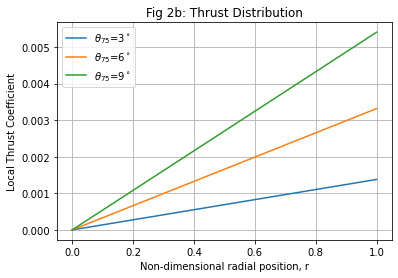

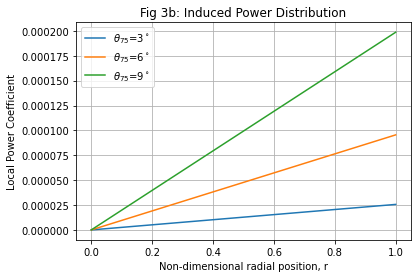

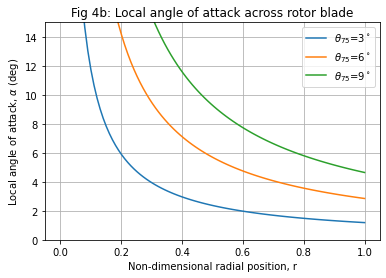

In [14]:
theta_75_list_deg = np.array([3,6,9])
theta_75_list_rad = np.deg2rad(theta_75_list_deg)

for i, theta_75 in enumerate(theta_75_list_rad):

    CT, CP = calc_CT_CP(theta_75, rotor)

    rs = np.linspace(0.0001, 1, 100)  # Non-dimensional blade radius

    plt.figure(1)
    plt.plot(rs, Lambda(rs, theta_75, rotor),label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")

    plt.figure(2)
    plt.plot(rs, dCT(rs, theta_75, rotor), label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")

    plt.figure(3)
    plt.plot(rs, dCP(rs, theta_75, rotor), label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")

    plt.figure(4)
    plt.plot(rs, np.rad2deg(Alpha(rs, theta_75, rotor)), label=fr"$\theta_{{75}}$={theta_75_list_deg[i]:.0f}$^\circ$")
    
plt.figure(1)
plt.title("Fig 1b: Inflow Distribution")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Inflow Ratio")
plt.legend()

plt.figure(2)
plt.title("Fig 2b: Thrust Distribution")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Thrust Coefficient")
plt.legend()

plt.figure(3)
plt.title("Fig 3b: Induced Power Distribution")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel("Local Power Coefficient")
plt.legend()

plt.figure(4)
plt.title("Fig 4b: Local angle of attack across rotor blade")
plt.grid()
plt.xlabel("Non-dimensional radial position, r")
plt.ylabel(r"Local angle of attack, $\alpha$ (deg)")
plt.ylim([0,15])
plt.legend()

#### Performance as a Function of Input Collective

The next step of the analysis is to calculate the total performance coefficients $C_T$ and $C_P$ as a function of input collective $\theta_{75}$. In order to better understand these plots, I wanted to approximate the maximum value for input collective, which I indicate with a red dashed line in the plots below. For the ideal twist distribution, the local airfoils on the rotor blade near the hub have the largest angles of attack, and are at risk of stalling (figure 4 above) when the input collective $\theta_{75}$ is too large. For this reason, I identified the approximate $\theta_{75}$ at which the local AoA at $r_{hub}=0.2$ is greater than $15^\circ$. Therefore, to the right of the red dashed lines in each plots below, there is a risk of stall at the base of the rotor blades. This also helps us better determine the maximum blade performance, especially since the performance coefficients will increase monotonically with input collective, as we will see.

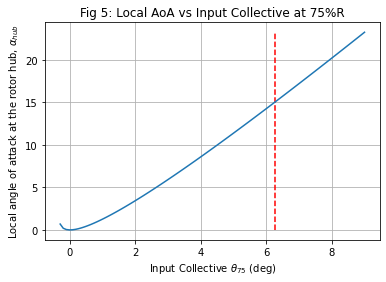

In [6]:
# Code for plotting Performance as a function of input collective
r_hub = 0.2  # non-dimensional radius of the hub
N_thetas = 100
theta75_deg = np.linspace(-0.3,9,N_thetas)
theta75_rad = np.deg2rad(theta75_deg)

CT_list = np.zeros(N_thetas)
CP_list = np.zeros(N_thetas)
lambda_list = np.zeros(N_thetas)
alpha_hub_list = np.zeros(N_thetas)

for i in range(N_thetas):
    lambda_list[i] = Lambda(1, theta75_rad[i], rotor)  # note: r=1 is arbitray since lambda=const(r) for ideal twist
    CT_list[i], CP_list[i] = calc_CT_CP(theta75_rad[i], rotor)
    alpha_hub_list[i] = np.rad2deg(Alpha(r_hub, theta75_rad[i], rotor))

# Determine approximate index of stall: where AoA > 15 deg at r_hub
stall_indx = np.where(alpha_hub_list>15)[0][0]
theta75_stall = theta75_deg[stall_indx]

plt.figure(5)
plt.title('Fig 5: Local AoA vs Input Collective at 75%R')
plt.plot(theta75_deg, alpha_hub_list)
plt.vlines(x=theta75_stall, ymin=min(alpha_hub_list), ymax=max(alpha_hub_list), color='r', linestyle='--')
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel(r"Local angle of attack at the rotor hub, $\alpha_{hub}$")
plt.grid()

The plots below show $\lambda$, $C_T$, and $C_P$, each as a function of $\theta_{75}$.

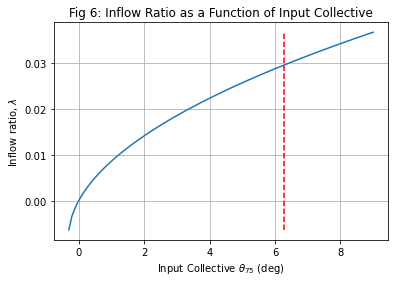

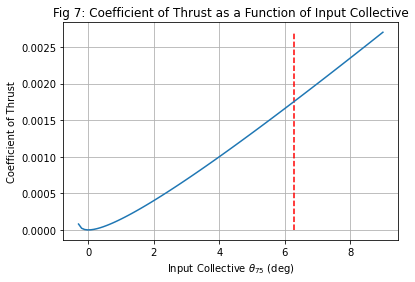

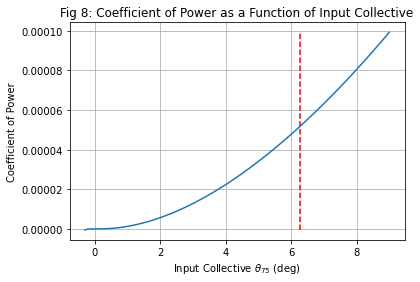

In [7]:
plt.figure(6)
plt.title("Fig 6: Inflow Ratio as a Function of Input Collective")
plt.plot(theta75_deg, lambda_list)
plt.vlines(x=theta75_stall, ymin=min(lambda_list), ymax=max(lambda_list), color='r', linestyle='--')
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel(r"Inflow ratio, $\lambda$")
plt.grid()

plt.figure(7)
plt.title("Fig 7: Coefficient of Thrust as a Function of Input Collective")
plt.plot(theta75_deg, CT_list)
plt.vlines(x=theta75_stall, ymin=min(CT_list), ymax=max(CT_list), color='r', linestyle='--')
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel("Coefficient of Thrust")
plt.grid()

plt.figure(8)
plt.title("Fig 8: Coefficient of Power as a Function of Input Collective")
plt.plot(theta75_deg, CP_list)
plt.vlines(x=theta75_stall, ymin=min(CP_list), ymax=max(CP_list), color='r', linestyle='--')
plt.xlabel(r"Input Collective $\theta_{75}$ (deg)")
plt.ylabel("Coefficient of Power")
plt.grid()